In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Dependencies

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor

#Train

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Hahaton zinc/data.csv', sep = ',')
df = df.drop(columns=['Unnamed: 0', 'DateTime'])
df = df.loc[df["CuOut"] <= 200]
df = df.loc[df["CdOut"] <= 1000]
df.head()

In [ ]:
seed = 42
train_size = 0.85

df_train = df.sample(frac=train_size, random_state=seed)
df_test = df.drop(df_train.index)

df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

X_train = df_train_copy.drop(['CuOut', 'CdOut', 'ZnOut'], axis=1)
X_test = df_test_copy.drop(['CuOut', 'CdOut', 'ZnOut'], axis=1)

y_train = df_train_copy[['CuOut', 'CdOut', 'ZnOut']].copy()
y_test = df_test_copy[['CuOut', 'CdOut', 'ZnOut']].copy()

In [ ]:
def calculate_score(X, model):
    y = model.predict(X)
    cu_err = np.abs(y_test.values[:,0] - y[:,0]).mean()
    cd_err = np.abs(y_test.values[:,1] - y[:,1]).mean()
    zn_err = np.abs(y_test.values[:,2] - y[:,2]).mean()
    return np.array((cu_err, cd_err, zn_err)).transpose().squeeze()

In [ ]:
from pandas.core.common import random_state

splitter = 'best'
criterion = 'squared_error'
max_depth = None
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0.0
max_features = None
max_leaf_nodes = None
min_impurity_decrease = 0.0
ccp_alpha = 0.0

def Regressor(rnd):
    return MultiOutputRegressor(DecisionTreeRegressor(
        random_state=rnd, 
        splitter=splitter, 
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=min_impurity_decrease,
        ccp_alpha=ccp_alpha))
    #return MultiOutputRegressor(ExtraTreesRegressor(random_state=rnd, n_estimators=300, criterion='absolute_error'))

In [ ]:
regr = Regressor(seed).fit(X_train.values, y_train.values)

In [ ]:
score = calculate_score(X_test.values, regr)#regr.score(X_test.values, y_test.values)
print(f'Средняя абсолютная ошибка на тестовой выборке: {score}')

score = regr.score(X_test.values, y_test.values)
print(f'score: {score}')

Средняя абсолютная ошибка на тестовой выборке: [1.60294418 5.08209216 0.21022058]
score: 0.9587239571045746


In [ ]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [ ]:
regression_results(y_test.values, regr.predict(X_test.values))

explained_variance:  0.9587
mean_squared_log_error:  0.0124
r2:  0.9587
MAE:  2.2984
MSE:  163.0645
RMSE:  12.7697


In [ ]:
import pickle
filename = 'zinc_model.sav'
pickle.dump(regr, open(filename, 'wb'))

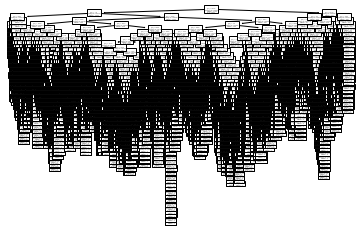

In [ ]:
from sklearn import tree
from matplotlib import pyplot as plt
tree.plot_tree(regr.estimators_[0])
plt.show()

#Inference

##Parse

In [ ]:
!pip install xlrd==1.2.0

def parse_to_dataFrame(path):
  df = pd.read_excel(path)
  df = df.drop(0)
  df = df.drop(columns = [' '])
  df = df.rename(columns = {"Unnamed: 0" : "DateTime"})
  df = df.astype({col: float for col in df.columns[1:]})
  df['DateTime'] =  pd.to_datetime(df['DateTime'], format='%d.%m.%Y %H:%M:%S')
  
  df = df.loc[(df["CHPAC1_B051_LV  --   AT501A"] + df["CHPAC1_B052_LV  --   AT501B"]) == 1 ]
  df = df.loc[(df["CHPAC1_B053_LV  --   AT502A"] + df["CHPAC1_B054_LV  --   AT502B"]) == 1 ]

  df1 = df.loc[(df["CHPAC1_B051_LV  --   AT501A"] == 1) & (df["CHPAC1_B053_LV  --   AT502A"] == 1)]
  df2 = df.loc[(df["CHPAC1_B052_LV  --   AT501B"] == 1) & (df["CHPAC1_B053_LV  --   AT502A"] == 1)]
  df3 = df.loc[(df["CHPAC1_B051_LV  --   AT501A"] == 1) & (df["CHPAC1_B054_LV  --   AT502B"] == 1)]
  df4 = df.loc[(df["CHPAC1_B052_LV  --   AT501B"] == 1) & (df["CHPAC1_B054_LV  --   AT502B"] == 1)]

  df1 = df1[["DateTime",
           "CHPAC1_M003_PV  --   расход после P510A",
           "CHPAC1_A023_PV  --   Cu - AT501A",
           "CHPAC1_A025_PV  --   Cd - AT501A",
           "CHPAC1_A024_PV  --   Zn - AT501A",
           "CHPAC1_M099_PV  --   температура TK501А",
           "CHPAC1_M129_PV  --   pH - TK501А",
           "CHPAC1_C102_PV  --   авто W503B",
           "CHPAC1_A033_PV  --   Cu - AT502A",
           "CHPAC1_A035_PV  --   Cd - AT502A",
           "CHPAC1_A034_PV  --   Zn - AT502A"
           ]]

  df3 = df3[["DateTime",
           "CHPAC1_M003_PV  --   расход после P510A",
           "CHPAC1_A023_PV  --   Cu - AT501A",
           "CHPAC1_A025_PV  --   Cd - AT501A",
           "CHPAC1_A024_PV  --   Zn - AT501A",
           "CHPAC1_M099_PV  --   температура TK501А",
           "CHPAC1_M129_PV  --   pH - TK501А",
           "CHPAC1_C102_PV  --   авто W503B",
           "CHPAC1_A038_PV  --   Cu - AT502B",
           "CHPAC1_A040_PV  --   Cd - AT502B",
           "CHPAC1_A039_PV  --   Zn - AT502B"
           ]]

  df2 = df2[["DateTime",
           "CHPAC1_M004_PV  --   расход после P510B",
           "CHPAC1_A028_PV  --   Cu - AT501B",
           "CHPAC1_A030_PV  --   Cd - AT501B",
           "CHPAC1_A029_PV  --   Zn - AT501B",
           "CHPAC1_M100_PV  --   температура TK501B",
           "CHPAC1_M130_PV  --   pH - TK501B",
           "CHPAC1_C102_PV  --   авто W503B",
           "CHPAC1_A033_PV  --   Cu - AT502A",
           "CHPAC1_A035_PV  --   Cd - AT502A",
           "CHPAC1_A034_PV  --   Zn - AT502A"
           ]]

  df4 = df4[["DateTime",
           "CHPAC1_M004_PV  --   расход после P510B",
           "CHPAC1_A028_PV  --   Cu - AT501B",
           "CHPAC1_A030_PV  --   Cd - AT501B",
           "CHPAC1_A029_PV  --   Zn - AT501B",
           "CHPAC1_M100_PV  --   температура TK501B",
           "CHPAC1_M130_PV  --   pH - TK501B",
           "CHPAC1_C102_PV  --   авто W503B",
           "CHPAC1_A038_PV  --   Cu - AT502B",
           "CHPAC1_A040_PV  --   Cd - AT502B",
           "CHPAC1_A039_PV  --   Zn - AT502B"
           ]]
  df1 = df1.rename(columns = {
                            "CHPAC1_M003_PV  --   расход после P510A" : "Sol",
                            "CHPAC1_A023_PV  --   Cu - AT501A" : "CuIn",
                            "CHPAC1_A025_PV  --   Cd - AT501A" : "CdIn",
                            "CHPAC1_A024_PV  --   Zn - AT501A" : "ZnIn",
                            "CHPAC1_M099_PV  --   температура TK501А" : "Temperature",
                            "CHPAC1_M129_PV  --   pH - TK501А" : "pH",
                            "CHPAC1_C102_PV  --   авто W503B" : "Dust",
                            "CHPAC1_A033_PV  --   Cu - AT502A" : "CuOut",
                            "CHPAC1_A035_PV  --   Cd - AT502A" : "CdOut",
                            "CHPAC1_A034_PV  --   Zn - AT502A" : "ZnOut"})

  df3 = df3.rename(columns = {
                            "CHPAC1_M003_PV  --   расход после P510A" : "Sol",
                            "CHPAC1_A023_PV  --   Cu - AT501A" : "CuIn",
                            "CHPAC1_A025_PV  --   Cd - AT501A" : "CdIn",
                            "CHPAC1_A024_PV  --   Zn - AT501A" : "ZnIn",
                            "CHPAC1_M099_PV  --   температура TK501А" : "Temperature",
                            "CHPAC1_M129_PV  --   pH - TK501А" : "pH",
                            "CHPAC1_C102_PV  --   авто W503B" : "Dust",
                            "CHPAC1_A038_PV  --   Cu - AT502B" : "CuOut",
                            "CHPAC1_A040_PV  --   Cd - AT502B" : "CdOut",
                            "CHPAC1_A039_PV  --   Zn - AT502B" : "ZnOut"})
  df2 = df2.rename(columns = {
                            "CHPAC1_M004_PV  --   расход после P510B" : "Sol",
                            "CHPAC1_A028_PV  --   Cu - AT501B" : "CuIn",
                            "CHPAC1_A030_PV  --   Cd - AT501B" : "CdIn",
                            "CHPAC1_A029_PV  --   Zn - AT501B" : "ZnIn",
                            "CHPAC1_M100_PV  --   температура TK501B" : "Temperature",
                            "CHPAC1_M130_PV  --   pH - TK501B" : "pH",
                            "CHPAC1_C102_PV  --   авто W503B" : "Dust",
                            "CHPAC1_A033_PV  --   Cu - AT502A" : "CuOut",
                            "CHPAC1_A035_PV  --   Cd - AT502A" : "CdOut",
                            "CHPAC1_A034_PV  --   Zn - AT502A" : "ZnOut"})

  df4 = df4.rename(columns = {
                            "CHPAC1_M004_PV  --   расход после P510B" : "Sol",
                            "CHPAC1_A028_PV  --   Cu - AT501B" : "CuIn",
                            "CHPAC1_A030_PV  --   Cd - AT501B" : "CdIn",
                            "CHPAC1_A029_PV  --   Zn - AT501B" : "ZnIn",
                            "CHPAC1_M100_PV  --   температура TK501B" : "Temperature",
                            "CHPAC1_M130_PV  --   pH - TK501B" : "pH",
                            "CHPAC1_C102_PV  --   авто W503B" : "Dust",
                            "CHPAC1_A038_PV  --   Cu - AT502B" : "CuOut",
                            "CHPAC1_A040_PV  --   Cd - AT502B" : "CdOut",
                            "CHPAC1_A039_PV  --   Zn - AT502B" : "ZnOut"})
  df = pd.concat([df1, df2, df3, df4], ignore_index=True)
  df = df.sort_values(by=['DateTime'])
  df = df.loc[(df["CuIn"] >= 1) &
              (df["CdIn"] >= 1) &
              (df["ZnIn"] >= 1) 
            ]
  df = df.set_index('DateTime')
  return df

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 103 kB 5.3 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [ ]:
df_validate = parse_to_dataFrame('/content/drive/MyDrive/Hahaton zinc/2019_07 - проверка - входные переменные.xls')

In [ ]:
#df_validate = df_validate.drop(columns=['DateTime'])

##Predict

In [ ]:
df_validate.shape

In [ ]:
X_val = df_validate.drop(['CuOut', 'CdOut', 'ZnOut'], axis=1)
y_val = regr.predict(X_val.values)
print(pd.DataFrame(X_val).shape)
df_validate['CuOut'] = pd.DataFrame(y_val)[0]
df_validate['CdOut'] = pd.DataFrame(y_val)[1]
df_validate['ZnOut'] = pd.DataFrame(y_val)[2]
df_validate

In [ ]:
import pickle

def predict(df, model_path):
    X = df.drop(['CuOut', 'CdOut', 'ZnOut'], axis=1)

    model = pickle.load(open(model_path, 'rb'))

    y = model.predict(X.values)
    
    df['CuOut'] = pd.DataFrame(y)[0]
    df['CdOut'] = pd.DataFrame(y)[1]
    df['ZnOut'] = pd.DataFrame(y)[2]

    return df

In [ ]:
predict(df_validate, '/content/drive/MyDrive/Hahaton zinc/zinc_model_v1.0.sav')